In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('brain-tumor-mri-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0000.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0001.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0002.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0003.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0004.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0005.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0006.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0007.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0008.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-glTr_0009.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0010.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0011.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0012.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0013.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0014.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0015.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0016.jpg
brain-tumor-mri-dataset\Testing\glioma\Te-gl_0017.jpg
brain-tu

In [15]:
# For the Model
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from keras import backend as K

# For Loading the Dataset, Preprocessing and Train-test Split
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Load/Read the Dataset
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 75
train_folder_path = 'brain-tumor-mri-dataset/Training'
test_folder_path = 'brain-tumor-mri-dataset/Testing'

# Load the training dataset
train_images = []
train_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(train_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        train_images.append(img)
        train_labels.append(i)

# Load the test dataset for use in model.evaluate
test_images = []
test_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(test_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        test_images.append(img)
        test_labels.append(i)

# Convert the image data and label arrays to NumPy arrays
X_train = np.array(train_images)
Y_train = np.array(train_labels)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

# Convert the label arrays to integers
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
    
#shuffle training dataset
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5712, 75, 75, 3)

In [33]:
# Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Define folder paths
train_dir = 'brain-tumor-mri-dataset/Training'
test_dir = 'brain-tumor-mri-dataset/Testing'

# Define image dimensions
img_height = 128
img_width = 128

# Define ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    # Data augmentation and rescaling parameters
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255
)

# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data batches from folders; target size affects the size of imgs in data batches...
#...but does not affect the actual image data that is loaded from the disk...
#...actual img from disk (that is fed in model) is affected by image size = 150 in preprocessing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [34]:
# train-test split
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train,test_size=0.1,random_state=101)

# convert integer labels to one-hot encoded categorical labels as required by categorical cross-entropy loss
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = len(labels))
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes = len(labels))

In [36]:
# Proposed 10-Layer Model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(206, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [38]:
# Def Precision, Recall and F1 score 
from keras.metrics import Precision, Recall
from keras import backend as K

def f1_score(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum ((1-y_true) * y_pred)
    fn = K.sum(y_true * (1-y_pred))
    precison = tp / (tp + fn + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1_score = 2*((precison*recall)/ (precison+recall+K.epsilon()))
    return f1_score

# Early Stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor= 'val_loss', patience = 3)

# Model Compilation
from tensorflow.keras.optimizers import Adam
model.compile(loss= 'categorical_crossentropy',optimizer= Adam(learning_rate= 0.001),metrics=['accuracy', f1_score, Precision(), Recall()])

In [39]:
model.save('projectbraintumor.h5')

In [40]:
history = model.fit(X_train, Y_train, batch_size = 64, epochs= 20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
73/73 [==============================] - 7s 53ms/step - loss: 22.8054 - accuracy: 0.4693 - f1_score: 0.3165 - precision_2: 0.4961 - recall_2: 0.3158 - val_loss: 1.1926 - val_accuracy: 0.5584 - val_f1_score: 0.0573 - val_precision_2: 0.7857 - val_recall_2: 0.0642
Epoch 2/20
73/73 [==============================] - 3s 41ms/step - loss: 0.9366 - accuracy: 0.6284 - f1_score: 0.4838 - precision_2: 0.6987 - recall_2: 0.4842 - val_loss: 0.9740 - val_accuracy: 0.6615 - val_f1_score: 0.2031 - val_precision_2: 0.7905 - val_recall_2: 0.2276
Epoch 3/20
73/73 [==============================] - 3s 41ms/step - loss: 0.8235 - accuracy: 0.6708 - f1_score: 0.5605 - precision_2: 0.7302 - recall_2: 0.5616 - val_loss: 0.8687 - val_accuracy: 0.6829 - val_f1_score: 0.3056 - val_precision_2: 0.8462 - val_recall_2: 0.3424
Epoch 4/20
73/73 [==============================] - 3s 41ms/step - loss: 0.7249 - accuracy: 0.7194 - f1_score: 0.6397 - precision_2: 0.7662 - recall_2: 0.6405 - val_loss: 0.7027 - 

In [42]:
# Load/Read the Dataset
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 75
train_folder_path = 'brain-tumor-mri-dataset/Training'
test_folder_path = 'brain-tumor-mri-dataset/Testing'

# Load the training dataset
train_images = []
train_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(train_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        train_images.append(img)
        train_labels.append(i)

# Load the test dataset for use in model.evaluate
test_images = []
test_labels = []
for i, label in enumerate(labels):
    folder_path = os.path.join(test_folder_path, label)
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        img = cv2.resize(img, (image_size, image_size))
        test_images.append(img)
        test_labels.append(i)

# Convert the image data and label arrays to NumPy arrays
X_train = np.array(train_images)
Y_train = np.array(train_labels)
X_test = np.array(test_images)
Y_test = np.array(test_labels)

# Convert the label arrays to integers
Y_train = Y_train.astype(int)
Y_test = Y_test.astype(int)
    
#shuffle training dataset
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(5712, 75, 75, 3)

In [43]:
# Classification Report
from sklearn.metrics import classification_report

Y_true = test_generator.classes
Y_pred = model.predict(X_test)
predicted_labels = np.argmax(Y_pred, axis=-1)

print(classification_report(Y_true, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.90      0.86      0.88       300
  meningioma       0.83      0.75      0.79       306
     notumor       0.94      0.97      0.96       405
   pituitary       0.87      0.98      0.92       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.89      0.89      0.89      1311



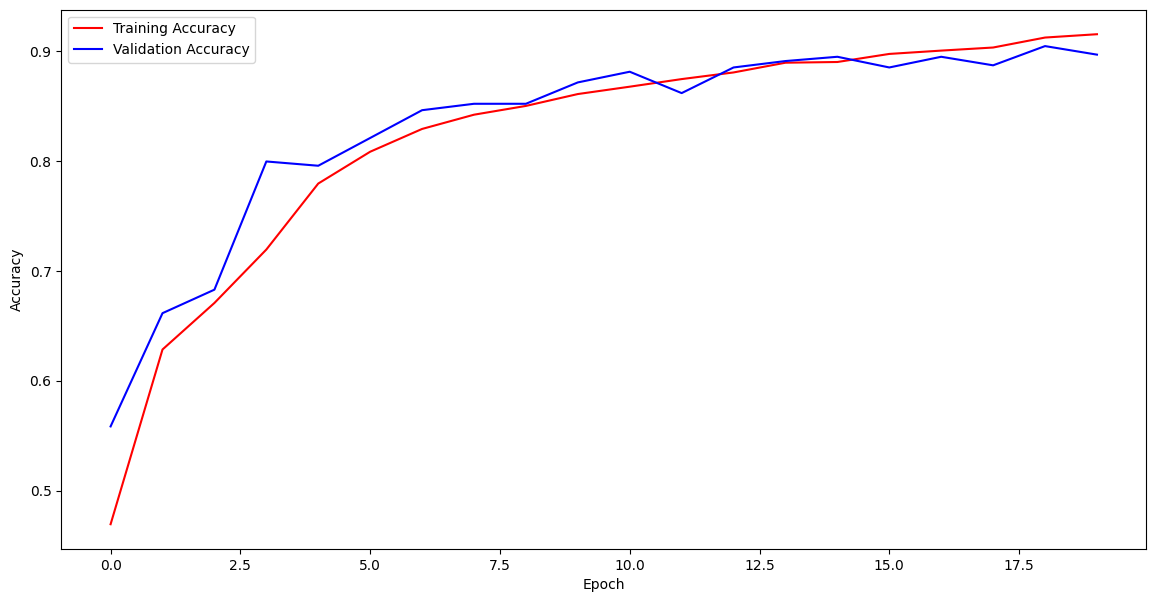

In [44]:
# Graphs of Training and Validation Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc)) # def range of vakues for x-axis as number of epochs
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc,'r',label="Training Accuracy")
plt.plot(epochs, val_acc,'b',label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('Graphs of Training and Validation Accuracy.png') # to download img
plt.show()

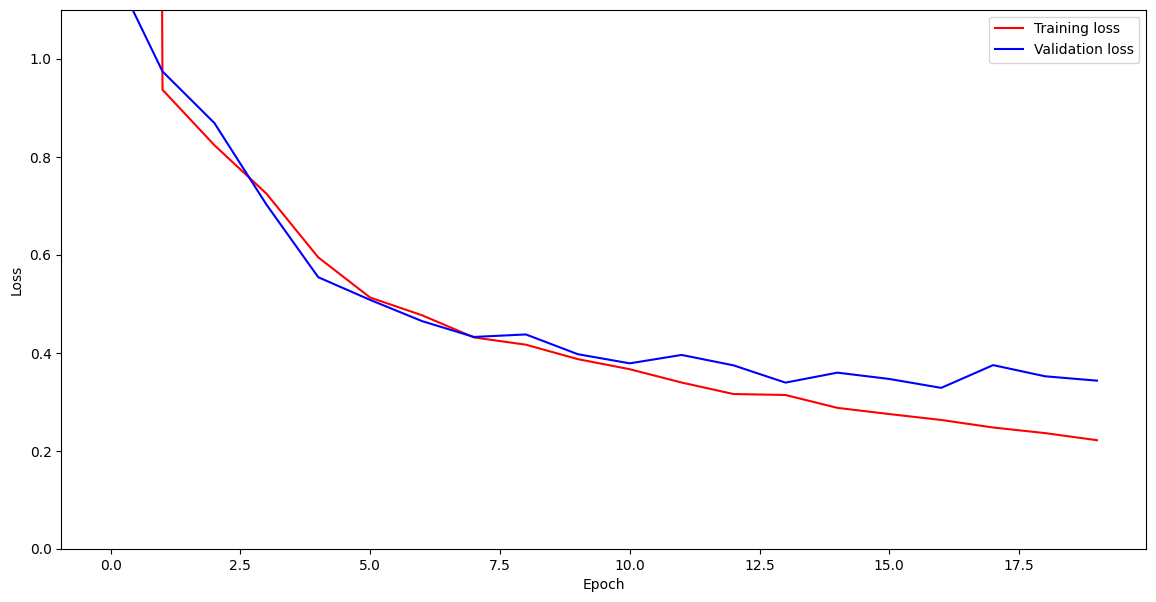

In [45]:
# Graphs of Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1.1)
plt.savefig('Graphs of Training and Validation Loss.png') # to download img
plt.show()

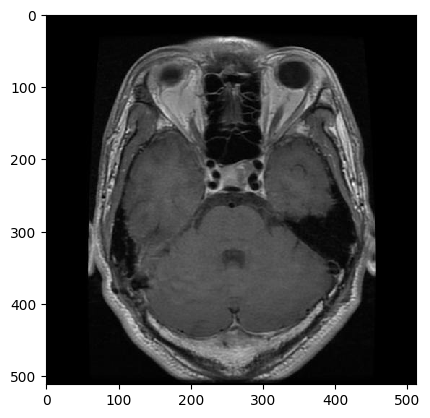

In [48]:
# Read an image from the dataset to use for prediction
img = cv2.imread('brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0000.jpg')
img = cv2.resize(img,(75,75))
img_array = np.array(img)
img_array.shape

# Reshape the image array to have a batch size of 1
img_array = img_array.reshape(1,75,75,3)
img_array.shape

# Load and display the image
from tensorflow.keras.preprocessing import image
img = image.load_img('brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0000.jpg')
plt.imshow(img,interpolation='nearest')
plt.savefig('Pituitary.png') # to download img
plt.show()

In [49]:
# Prediction
a=model.predict(img_array)
indices = a.argmax()
indices

3

In [50]:
# Train-Test-Validation Dataset Distribution Per Class
from collections import defaultdict

# Load dataset and labels
dataset = np.random.randint(0, 10, size=(7022, 2))  
labels = np.random.randint(0, 4, size=(7022,))  

# Define the desired train-test-validation split ratios
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Create a dictionary to store samples for each class
class_samples = defaultdict(list)
for i, label in enumerate(labels):
    class_samples[label].append(dataset[i])

# Split samples for each class into train, test, and validation sets
train_set = []
test_set = []
val_set = []

for class_label, samples in class_samples.items():
    num_samples = len(samples)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = int(num_samples * test_ratio)
    num_val_samples = num_samples - num_train_samples - num_test_samples

   # Set same random seed as train test split, to get exact values for each set
    np.random.seed(101)  
    
    # Split samples for each class into sets
    train_set.extend(samples[:num_train_samples])
    test_set.extend(samples[num_train_samples:num_train_samples+num_test_samples])
    val_set.extend(samples[num_train_samples+num_test_samples:])

# Convert sets back to numpy arrays
train_set = np.array(train_set)
test_set = np.array(test_set)
val_set = np.array(val_set)

# Print the number of samples in each set for each class
for class_label, samples in class_samples.items():
    num_train_samples = int(len(samples) * train_ratio)
    num_test_samples = int(len(samples) * test_ratio)
    num_val_samples = len(samples) - num_train_samples - num_test_samples

    print("Class Label:", class_label)
    print("Number of samples in train set:", num_train_samples)
    print("Number of samples in test set:", num_test_samples)
    print("Number of samples in validation set:", num_val_samples)

Class Label: 2
Number of samples in train set: 1369
Number of samples in test set: 171
Number of samples in validation set: 172
Class Label: 1
Number of samples in train set: 1419
Number of samples in test set: 177
Number of samples in validation set: 178
Class Label: 0
Number of samples in train set: 1433
Number of samples in test set: 179
Number of samples in validation set: 180
Class Label: 3
Number of samples in train set: 1395
Number of samples in test set: 174
Number of samples in validation set: 175


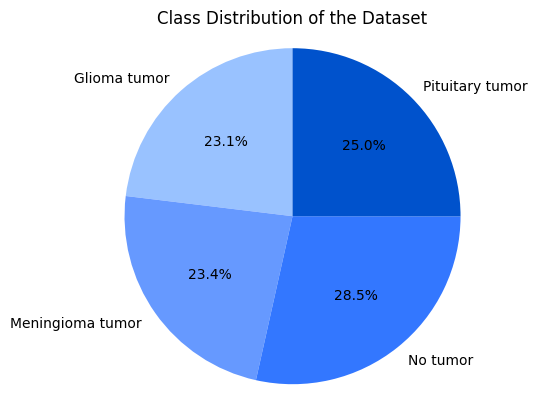

In [51]:
# Pie Chart for Class Distribution of Dataset
numbers = [1621, 1645, 2000, 1757] 
total = sum(numbers)
percent = [(num /total) * 100 for num in numbers]
colors = ['#99c2ff', '#6699ff', '#3377ff', '#0052cc']
labels=['Glioma tumor','Meningioma tumor', 'No tumor', 'Pituitary tumor'] #needed cus labels is defined again below but with diff elements

# Create the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(percent, colors = colors, labels = labels, autopct = '%1.1f%%', startangle = 90)
ax1.axis('equal')
plt.title("Class Distribution of the Dataset")
plt.savefig('Class Distribution of the Dataset.png') # to download img
plt.show()

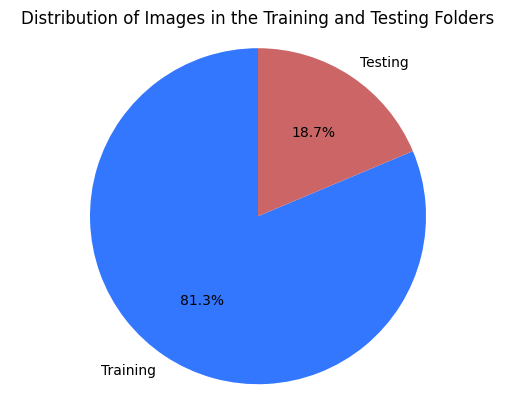

In [52]:
# Pie chart for Image Distribution in Training and Testing Folders
train = 5712
test = 1311
total = train + test
train_percent = (train / total) * 100
test_percent = (test / total) * 100
labels = ['Training', 'Testing']
percent = [train_percent, test_percent]
colors = ['#3377ff', '#cc6666']

# Create the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(percent, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title("Distribution of Images in the Training and Testing Folders")
plt.savefig('Distribution of Images in the Training and Testing Folders.png') # to download img
plt.show()

Shape of true_labels: (1311,)
Data type of true_labels: int32
Shape of predicted_labels: (1311,)
Data type of predicted_labels: int64


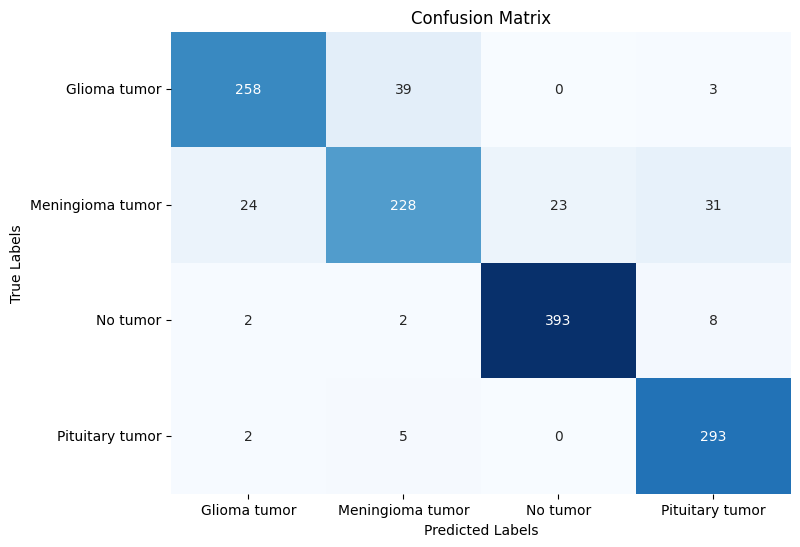

In [53]:
# Confusion Matrix
# Get the shapes and data shapes of true and predicated labels
true_labels = test_generator.classes
y_pred = model.predict(X_test) #y pred is the predicted labels
predicted_labels = np.argmax(y_pred, axis=-1) # Convert predicted probabilities to class labels

# Display results; can skip this but helps to know if the shapes are the same (syntax: (no of imgs in test dataset,))...
#...confusion matrix won't work if they are different
# if diff, run 'load from datset' then the code beneath it to confirm shape is (1311,), then run confusion matrix again
print("Shape of true_labels:", true_labels.shape)
print("Data type of true_labels:", true_labels.dtype)
print("Shape of predicted_labels:", predicted_labels.shape)
print("Data type of predicted_labels:", predicted_labels.dtype)

labels = ['Glioma tumor', 'Meningioma tumor', 'No tumor', 'Pituitary tumor']

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix/ actual diagram
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)# +0.5 sets x-tick to be centered between each row
plt.yticks(rotation=0, ticks=np.arange(len(labels)) + 0.5, labels=labels)# rotation sets labels on y-axis to horizontal
plt.savefig('Confusion Matrix.png') # to download img
plt.show()